## Imports

In [1]:
# Import some "default" libraries
# You can now use Pandas to manipulate the Dataframe conveniently

''' Data manipulation'''
import numpy as np
import pandas as pd

''' Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

# 🚀 Real Estate - Advanced Estimator

❗️ In the previous challenge, we saw that if we have more flats than features in our dataset ($\large n$ observations $\large> p$ features) we can't "solve" the equation $\large \boldsymbol X \cdot \boldsymbol \theta = \boldsymbol y $. Without a deterministic formula for $\large \boldsymbol \theta$, we would no longer be able to predict the prices of new flats!

----

🎯 In this exercise, we now have access to a bigger dataset consisting of 1000 flats, and we want to refine our prediction for the same new flat as before:

- `Surface`: 3000 $ft^2$
- `Bedrooms`: 5 
- `Floors`: 1

❌ Instead of solving $\large \boldsymbol X \cdot \boldsymbol \theta = \boldsymbol y $ with a matrix $\large \boldsymbol X$ of shape $ (1000,4)$ that is **`non-invertible`**...

🚀 ...we will find a $\large {\boldsymbol \theta} = \begin{bmatrix}
     \theta_0 \\
     \theta_1 \\
    \theta_2 \\
     \theta_3
\end{bmatrix}_{4 \times 1}$ that minimizes the error $ \large \boldsymbol e = \boldsymbol X \cdot \hat{\boldsymbol \theta} - \boldsymbol y  $; this approach is called a **`Linear Regression model`**. We will measure this error $\boldsymbol e$ using the Euclidean distance $\large \left\|\boldsymbol e\right\|$ and the **`Mean Squared Error.`**

👉 Let's compute $\large \hat{\boldsymbol \theta}$ to find an approximate estimation of the new flat's price.


## (1) Data Exploration

We load the dataset `flats.csv` below

In [2]:
flats = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/flats.csv')
flats.head(10)

,price,bedrooms,surface,floors
0,274.0,3,1830,2.0
1,500.0,4,2120,1.0
2,320.0,3,1260,1.0
3,445.5,3,1880,1.0
4,637.5,3,1680,1.0
5,460.0,2,2730,1.0
6,259.0,3,1270,1.5
7,950.0,3,2780,1.0
8,550.0,3,1930,2.0
9,265.5,3,1860,1.0


👀 Use `scatterplots` to visually figure out <u><i>which feature gives the most information about prices:</i></u>``

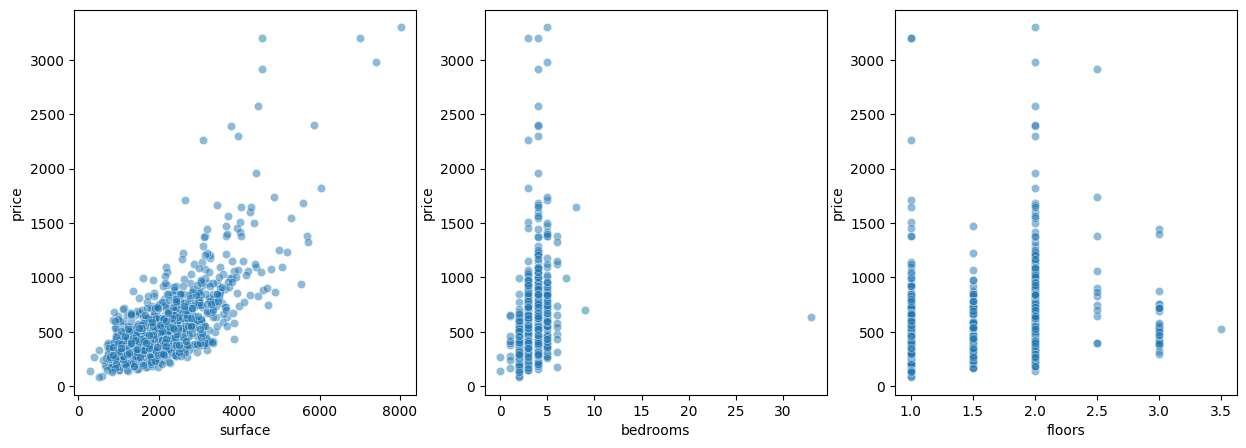

In [5]:
# YOUR CODE HERE
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x= 'surface', y='price', data=flats, alpha=0.5, ax=ax1)
sns.scatterplot(x= 'bedrooms', y='price', data=flats, alpha=0.5, ax=ax2)
sns.scatterplot(x= 'floors', y='price', data=flats, alpha=0.5, ax=ax3);

👉 It seems that `surface` is a stronger indicator of price than the number of bedrooms or floors. In statistics, we say that `price` is more **correlated** with `surface` than with other features. 

👉 Let's double-check this by running [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) below, which computes correlation coefficients between each pair of columns of the DataFrame. 

<i> <u>Remarkable values:</u></i>
* 1 means that the two columns are perfectly correlated 📈 
* -1 means that the two columns are perfectly inversely correlated 📉 
* 0 means that the two columns are not *linearly* correlated 😐
    
<details>
    <summary><i>Why do we use the correlation coefficient and not the covariance coefficient?</i></summary>

✅ <u>Similarities</u>:
    
- 📈 Positive correlations and positive covariances between two variables X and Y mean the same thing: when X increases, Y increases, and vice-versa.
- 📉 Negative correlations and negative covariances between two variables X and Y mean the same thing: when X increases, Y decreases, and vice-versa.
- 🤔 A null correlation and a null covariance between two variables X and Y mean the same thing: 
    - They are _not linearly correlated_ in the sense that there would exist two real numbers $a$ and $b$  such that $ Y = aX + b$ 
    - However, they could still have a different type of relation such as $Y = X^{2}$ (quadratic relation), $Y = e^{X}$ (exponential relation), $Y = ln(X)$ (logarithmic relation), $Y = sin(\sqrt{1+X^7})$ (super weird relation), etc.

❗️<u>Main differences</u>:

- 😖 The covariance between two variables X and Y can be either infinitely positive or infinitely negative: $ cov(X, Y) \in ( - \infty ; + \infty ) $
    Example: if $ cov (X, Y) = 10 $ and $ cov (X, Z) = 30 $, can you say that X and Z are "more correlated"? _No_, because you cannot compare apples, oranges, and bananas.

    🧑🏻‍🏫 How to solve this problem? Consider the correlation instead, often denoted by the Greek Letter $\rho$ (pronounce "rhô")

👉 <u>Consequence</u>:

- You can view the correlation as a _standardized covariance_, we simply divide the covariance by both the standard deviation of $X$ and the standard deviation of $Y$    
$$ \large  \rho(X,Y) = \frac{cov(X,Y)}{\sigma_X \sigma_Y} \in [0;1]$$

Continuing our example: suppose now that $ \rho(X, Y) = 0.80 $ and $ \rho(X, Z) = 0.15 $, would you still want to say that X and Z are more correlated? No; in fact, X and Y are more correlated than X and Z!
</details>

In [7]:
# YOUR CODE HERE
flats.corr()

,price,bedrooms,surface,floors
price,1.000000,0.239623,0.732790,0.258263
bedrooms,0.239623,1.000000,0.417170,0.131993
surface,0.732790,0.417170,1.000000,0.357512
floors,0.258263,0.131993,0.357512,1.000000


🎨 For a quicker glimpse of this matrix, you can use a **heatmap** from [`seaborn.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

<details>
    <summary><i>Additional tips to display a nicer correlation matrix</i></summary>

- `cmap`: **Seaborn** being a visualization library built on top of **Matplotlib**, you can use the argument [`cmap`](https://matplotlib.org/stable/tutorials/colors/colormaps.html), which stands for _color map_
- `annot`: to read the correlations even faster, you can show the correlation coefficients directly on the colored heatmap
- `annot_kws`: you can customize how the correlation coefficients appear
</details>

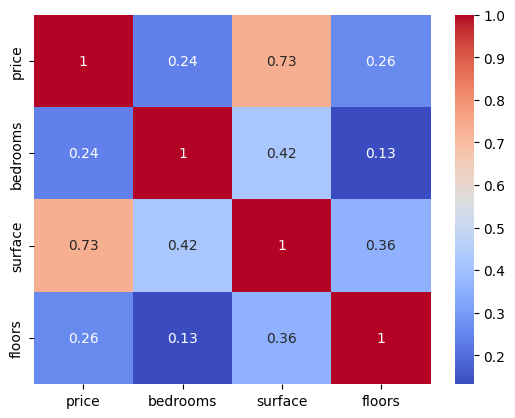

In [12]:
# YOUR CODE HERE
sns.heatmap(
    flats.corr(),
    cmap = "coolwarm", 
    annot = True,
    annot_kws = {'fontsize':10}
);

**🧪 Test your code!**

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'flats',
    shape=flats.shape,
    columns=flats.columns
)

result.write()
print(result.check())

## (2) Estimator with 1 Feature

Let's try to build a statistical estimator of **price** as a function of only one feature: the **surface**.

🎯 Let's try to fit a **linear regression** between the two variables.

Practically speaking, we want to choose the best parameters $\hat{\boldsymbol \theta}$ = (`slope`, `intercept`) such that the `predicted price = slope * surface + intercept` is as close as possible to the `price` in terms of Mean Squared Error (MSE).

📅 During the next weeks, we will discover and study different models (Linear Regression, KNN, Logistic Regression, Neural Networks, etc.). 

👉 An important part of your job is to choose the right model and optimize the parameters to make the best predictions.

### (2.1) Visual Approach

❓Implement the function `plot_line(slope, intercept)`

When given the `slope` and `intercept` arguments, this function creates an array `predicted_price` and plots that array on top of the original (scattered) data.

When you are done with coding the function, play with different values of `(slope, intercept)` until you find a “good linear approximation” of the data. Can you find the best fit?

Visual guideline:

<img src="https://wagon-public-datasets.s3.amazonaws.com/03-Maths/01-Algebra-Calculus/line_of_best_fit.png" width=400>

In [ ]:
def plot_line(data, slope, intercept):
    # First, we'll create x - an array of our independent variable values - for you.
    x = data['surface']

    # Now create an array of predicted prices using the predicted prices formula above
    # Remember, we can do mathematical operations on an entire array at once!
    y_pred = None
    

    # Finally, let's plot the line!
    plt.plot(x, y_pred);

Test your function by running the cell below, then change the values to see if you can approximate a good line of best fit!

*Hint: you can run `plot_line()` multiple times in the same cell to get several lines on the same scatterplot* 😉

In [ ]:
sns.scatterplot(x="surface", y="price", data=flats)
plot_line(flats, 1, 1)

😅 Not so easy (and not very “scientific”), right?

### (2.2) Computational Approach

🔥 To make sure that our estimator line is the best possible one, we need to compute the **Mean Squared Error** between the **real prices** and the **predicted prices**!

👉 Remember that:
- For each apartment, `predicted_price = slope * surface + intercept`
- Both the **vector of real prices** and the **vector of predicted prices** are of shape $ (1000, 1)$

#### (2.2.1) Squared Errors

<u><b>Step 1</b></u>

❓For each row (_i.e. flat_), we should evaluate the `squared_error = (price - predicted_price)**2`❓

In [ ]:
def compute_squared_errors(slope, intercept, surfaces, prices):
    """
    TODO: return an array containing the squared errors between 
    all real prices from the dataset and the predicted prices
    """
    pass  # YOUR CODE HERE

💡 A general principle in Data Science/Modeling is that $ \large error = f(\boldsymbol y, \hat{\boldsymbol y})$ where:

- $ \large \boldsymbol y $ is the real value
- $ \large \hat{\boldsymbol y} $ the predicted valute
- $ \large f$ is often called a **Loss Function** or a **Cost Function** 
    - 📆 See `Machine Learning I > Model Tuning`

#### (2.2.2) Mean Squared Errors (MSE)

<u><b>Step 2</b></u>

❓ Create the `mse` function which should return the mean of the array returned by the `squared_errors` function. ❓

In [ ]:
def compute_mse(slope, intercept, surfaces, prices):
    '''TODO: Return the mean of the array contained in squared_errors as a float.'''
    pass  # YOUR CODE HERE

👉 In section _(2.1) Visual approach_, you visually tried to estimate the "best line", which consists in finding the best pair `(slope, intercept)`. 

❓Using this "best pair", compute the MSE of your estimator. ❓

In [ ]:
# YOUR CODE HERE

### (2.3) Finding the Best Parameters

👉 Keep playing with different values for `slope` and `intercept` and try to get the best fit by hand!  Notice how hard it is to optimize both parameters at the same time.

👇 Follow the steps below to get an idea of one potential approach:

#### (2.3.1) Finding the Best Slope

<b><i><u> Step 1 :</u></i></b>

Start by fixing an  `initial_intercept` with your best estimate, then find a slope that approximately minimizes the function  `mse = f(slope)`

In [ ]:
# Define an initial_intercept, for instance, we may suppose there is always a small transaction fee even for very small flats


In [ ]:
# Create a range of 100 slopes that contains what you believe is the optimal slope (hint: np.linspace())


In [ ]:
# Create the list of MSEs for each slope value


❓Plot MSEs vs. slopes. Do you see a minimum❓

🙃 If not, try another range of slopes!

In [ ]:
# YOUR CODE HERE

❓Compute the minimum value of MSE for your `initial_intercept`, and the corresponding `slope_best` value❓
<br>
<details>
    <summary><i>Hint</i></summary>
    
Here you can use Python's built-in `.min()` function, as well as the `List.index()` method
    
</details>

In [ ]:
# YOUR CODE HERE

#### (2.3.2) Finding the Best Intercept

<b><i><u> Step 2 :</u></i></b>

🔨 Now, let's fix the slope to that `slope_best` value, then re-use the previous approach to find "the" `intercept_best`.

In [ ]:
# Create a range of 100 intercepts that contains what you believe is the optimal intercept


In [ ]:
# Create the list of MSEs for each intercept value


In [ ]:
# Plot MSEs against slopes. Do you see a minimum? If not, try another range of slopes!


❓Compute `mse_min`, the minimum value of MSEs when slope is equal to `slope_best`, and store the corresponding best intercept as `intercept_best`❓


In [ ]:
mse_min = None
intercept_best = None

In [ ]:
# YOUR CODE HERE

**🧪 Test your code!**

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    'univariate',
    mse_min=mse_min,                
    slope_best=slope_best,
    intercept_best=intercept_best
)

result.write()
print(result.check())

🎉 **Great job**! By adding a non-zero intercept parameter, we were able to reduce the MSE even more (feel free to plot the regression line on your scatter plot to visually confirm the approximate fit).

❓However, what guarantees that these (`intercept_best`, `slope_best`) parameters are really the best ones? 

<details>
    <summary>👀 Explanations</summary>

We could maybe find an even better slope value by repeating step ①, this time fixing the intercept at `intercept_best`, and then repeating step ② with the new slope to adjust the intercept again.

To find the global minimum of a 2-parameter function `rmse = f(slope, intercept)`, we may have to repeat steps ① and ② indefinitely until values converge towards absolute minima - with no guarantee of success.

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/decision-science/real-estate-minimizer.png'>

💪 You've just discovered one of the most fundamental aspects of Machine Learning: **the iterative process of finding minima**.

👉 As you might guess, in the world of Data Science, algorithms have been developed to automate and optimize such processes. In the next few weeks, you will discover the power of other algorithms such as **Gradient Descent**, and Python libraries such as `Statsmodels` that perform this iterative process for you.
</details>

👉 Run the cells below if you are curious and want to find the real best slope and intercept for this dataset, computed using **Gradient Descent** (📆 covered in **Machine Learning I > Under The Hood**).

In [ ]:
# Try this out (Seaborn visual solution)
sns.regplot(data=flats, x='surface', y='price')

In [ ]:
# Try this out (statsmodels, exact solution)!
import statsmodels.formula.api as smf

regression = smf.ols(formula= 'price ~ surface', data=flats).fit()

print("intercept_best", regression.params['Intercept'])
print("slope_best", regression.params['surface'])
print('mse_best: ', np.mean(regression.resid**2))

❓Let's go back to our initial question: what is your new prediction for the 5th flat below? How does it compare with your initial prediction based on only 4 flats?

- `surface`: 3000 $ft^2$
- `bedrooms`: 5 
- `floors`: 1

In [ ]:
# compute predicted price (Remember that the real price is 750,000$)
pass  # YOUR CODE HERE

☝️ It's better than our initial deterministic estimator based on only 4 flats, but obviously we are missing the information provided by the number of bedrooms and floors in this prediction!

## (3) Estimator with _All_ Features (`surface`, `bedrooms`, `floors`)?

💡 A linear regression with three features (**Multivariate Linear Regression**) works the same way as with one feature, but instead of determining only 2 parameters to minimize the RMSE (`intercept` and `slope`), we will need to find 4 parameters: $\hat{\boldsymbol \theta}$ = (`intercept`, `slope_surface`, `slope_bedrooms`, `slope_floors`).

🗓 There will be a lecture fully dedicated to **Multivariate Linear Regression** in the **Decision Science** module.

🗓 The same **Gradient Descent** iterative method is applicable, and you will code it yourself by hand later in the bootcamp.

👉 Meanwhile, feel free to run the cell below to see the final result of this multivariate regression:

In [ ]:
# Find the four regression coefficients by running this cell
regression = smf.ols(formula= 'price ~ surface + bedrooms + floors', data=flats).fit()
regression.params

🎉 Now that we have found the best parameters $\boldsymbol {\hat \theta}= \begin{bmatrix}
     \theta_0 \\
     \theta_1 \\
    \theta_2 \\
     \theta_3 \\
\end{bmatrix}_{4 \times 1} = 
\begin{bmatrix}
     \theta_{intercept} \\
     \theta_{surface}\\
    \theta_{bedrooms} \\
     \theta_{floors}
\end{bmatrix}_{4 \times 1} = 
\begin{bmatrix}
    18.154854 \\
    0.286953 \\
    -21.623564 \\
    -3.811868
\end{bmatrix}_{4 \times 1}
$, 

we can predict the price of the new flat with:
* $3000 ft^2$
* $5$ bedrooms
* located on the $1st$ floor

$$ \hat{y_5} = \theta_0 + \theta_1 \times 3000 + \theta_2 \times 5 + \theta_3 \times 1 $$

In [ ]:
# Compute the newly predicted price for the 5th flat? Is this prediction better?
pass  # YOUR CODE HERE

## (4) Concluding Remarks on Linear Algebra 🧠

This **optimization problem** can be summarized as follows

- We need to find a vector of parameters $\hat{\boldsymbol \theta} = \begin{bmatrix}
     \theta_{intercept} \\
     \theta_{surface}\\
    \theta_{bedrooms} \\
     \theta_{floors}
\end{bmatrix}_{4 \times 1}$ 

- That minimizes an error $e = \left\|\boldsymbol X\cdot \hat{\boldsymbol \theta} - \boldsymbol y  \right\|^2$

- For a given matrix of features $\boldsymbol X$ [constant, surfaces, floors, bedrooms]  $\begin{bmatrix}
    1 & 620 & 1 & 1 \\
    1 & 3280 & 4 & 2 \\
    ... \\
    1 & 1900 & 2 & 2 \\
    1 & 1320 & 3 & 3
   \end{bmatrix}_{n \times 4}
$

- and a vector of observations $\boldsymbol y  = \begin{bmatrix}
           y_{1} \\
           y_{2} \\
           \vdots \\
           y_{1000}
         \end{bmatrix}$ (prices)

Such a $\large \hat{\theta}$ is reached when the "derivatives" of $\boldsymbol e$, that is $ \large 2 \boldsymbol X^T\cdot (\boldsymbol X \cdot \hat{\theta}−\boldsymbol y )$, equal zero (👉 proof during the Decision Science module). 
    
In other words, we need to solve the linear system $\large (\boldsymbol X^T\cdot \boldsymbol X)\cdot \hat{\boldsymbol \theta}=\boldsymbol X^T \cdot \boldsymbol y $. 
    
This linear system has a unique solution provided that no column of $\boldsymbol X$ can be expressed as a linear combination of the others: in that case, $ \large (\boldsymbol X^T \cdot \boldsymbol X)^{-1}$ is invertible and the minimum is reached when $\large \hat{\boldsymbol \theta} = (\boldsymbol X^T\cdot \boldsymbol X)^{-1} \cdot \boldsymbol X^T \cdot \boldsymbol y $. Notice how $\boldsymbol X$ does not need to be squared anymore compared to the first challenge 💪.

💥 However, keep in mind that **inverting matrices is computationally complex**. That is why other methods have been developed to find the minimum of a function, such as **Gradient Descent**.
    
📚 Read more on [Stats.StackExchange](https://stats.stackexchange.com/a/278779) if you are interested!
</details>

🏁 Congratulations! 

💾 Don't forget to `git add/commit/push` your notebook!